In [1]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
import os

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

## Utility functions

In [2]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure(figsize=(20, 5))
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)
        

    return track, sr, onset_env, peaks
    
    

## Settings

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [4]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [5]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

## Audio signals

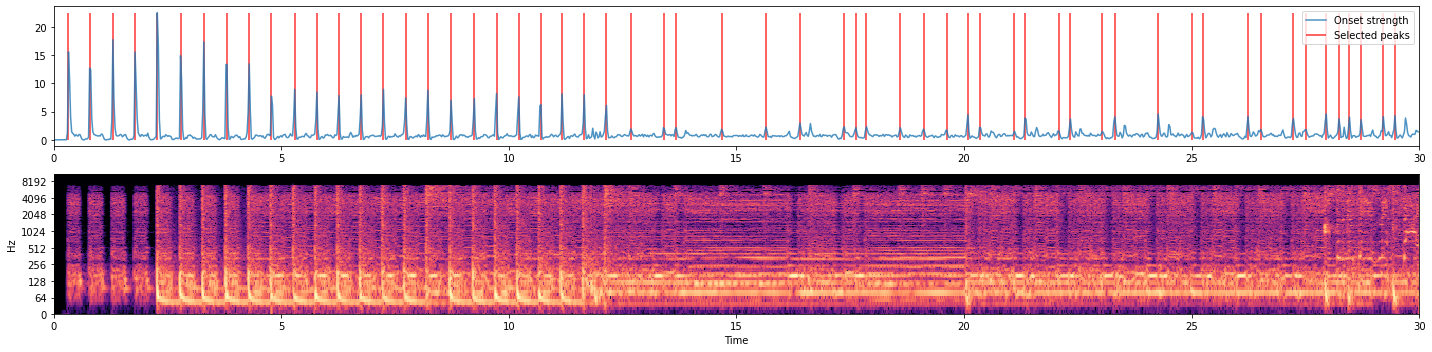

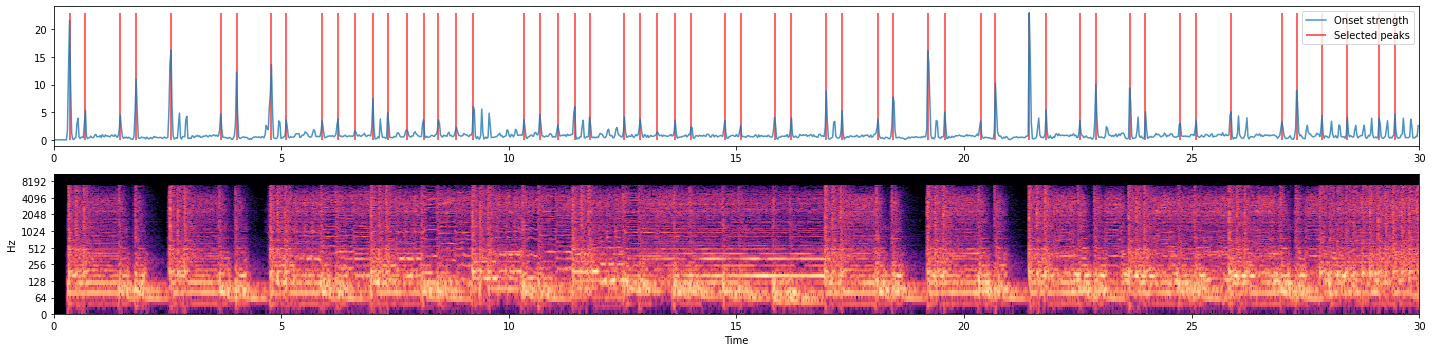

In [7]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)
        
        

## Minhash

ciao a tutti 

## Data wrangling
Now that we've these three datasets I'm going to analyse and merge it

In [8]:
import pandas as pd
echo = pd.read_csv('data/csv/echonest.csv')
print("Read echo")
tracks = pd.read_csv('data/csv/tracks.csv')
print("Read tracks")
features = pd.read_csv('data/csv/features.csv')
print("Read features")

Read echo
Read tracks
Read features


### Analysis of the datasets
In order to find the right key where we can merge, let's explore the datasets that we are facing with.<br>
These datasets are all in csv format and have very much colums, so for each datasets I've first analyzed the general info, then obtained the columns with nan values inside it and, at the end I've evaluated if these datasets contains some duplicates

Let's start with the first:
#### Echonest

In [9]:
echo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 250 entries, track_id to temporal_features_223
dtypes: float64(244), int64(1), object(5)
memory usage: 25.0+ MB


In [10]:
none_echo = echo.isna().sum()
none_echo[none_echo>0]

metadata_album_date              10412
metadata_album_name              10257
metadata_artist_latitude          3359
metadata_artist_location          3359
metadata_artist_longitude         3359
ranks_artist_discovery_rank      10304
ranks_artist_familiarity_rank    10304
ranks_artist_hotttnesss_rank     10305
ranks_song_currency_rank         11096
ranks_song_hotttnesss_rank       10923
dtype: int64

In [11]:
len(echo)-len(echo.drop_duplicates())

0

So:<br>
Echonest.csv has 13129 entries and 250 columns, 10 of them contains nan values and there aren't duplicates

#### Tracks

In [12]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   track_id                  106574 non-null  int64  
 1   album_comments            106574 non-null  int64  
 2   album_date_created        103045 non-null  object 
 3   album_date_released       70294 non-null   object 
 4   album_engineer            15295 non-null   object 
 5   album_favorites           106574 non-null  int64  
 6   album_id                  106574 non-null  int64  
 7   album_information         83149 non-null   object 
 8   album_listens             106574 non-null  int64  
 9   album_producer            18060 non-null   object 
 10  album_tags                106574 non-null  object 
 11  album_title               105549 non-null  object 
 12  album_tracks              106574 non-null  int64  
 13  album_type                100066 non-null  o

In [13]:
none_tracks = tracks.isna().sum()
print(len(none_tracks[none_tracks>0]))
none_tracks[none_tracks>0]

28


album_date_created            3529
album_date_released          36280
album_engineer               91279
album_information            23425
album_producer               88514
album_title                   1025
album_type                    6508
artist_active_year_begin     83863
artist_active_year_end      101199
artist_associated_labels     92303
artist_bio                   35418
artist_date_created            856
artist_latitude              62030
artist_location              36364
artist_longitude             62030
artist_members               59725
artist_related_projects      93422
artist_website               27318
artist_wikipedia_page       100993
track_composer              102904
track_date_recorded         100415
track_genre_top              56976
track_information           104225
track_language_code          91550
track_license                   87
track_lyricist              106263
track_publisher             105311
track_title                      1
dtype: int64

In [14]:
len(tracks)-len(tracks.drop_duplicates())

0

So:<br>
Tracks has 28 columns with nan value (one of which is the title), in total has 53 columns and 106574 distinct rows

#### Features

In [15]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


In [16]:
none_features = features.isna().sum()
none_features[none_features>0]

Series([], dtype: int64)

In [17]:
len(features)-len(features.drop_duplicates())

0

So:<br>
Features has 519 columns and no one of them has nan values, it has 106574 distinct rows

Let's now try to understand which is the most suitable attributes to use as joint key, intuitively all of these datasets has the **'track_id'** attribute, it's an ID, so maybe it'll be our field, but let's investigate a bit

In [18]:
echo.keys()[np.where(echo.nunique()==len(echo))]

Index(['track_id', 'audio_features_danceability', 'audio_features_energy',
       'audio_features_speechiness', 'temporal_features_074',
       'temporal_features_078', 'temporal_features_099',
       'temporal_features_127', 'temporal_features_171',
       'temporal_features_172', 'temporal_features_178',
       'temporal_features_194', 'temporal_features_199',
       'temporal_features_210'],
      dtype='object')

In [19]:
tracks.keys()[np.where(tracks.nunique()==len(tracks))]

Index(['track_id'], dtype='object')

In [20]:
features.keys()[np.where(features.nunique()==len(features))]

Index(['track_id'], dtype='object')

In [21]:
set(features.keys()).intersection(set(tracks.keys())).intersection(set(echo.keys()))

{'track_id'}

It's pretty clear that the field of above is the one that is unique in all three datasets, so it's the unique field that can be used as key, it's also the most usefull one and the **most important** is that it's the unique field common between the three datasets.

So now we've to select the keys common to the three datasets and pick, from each dataset the subset of entries that has this set of keys.

In [22]:
len(set(features.track_id).intersection(set(tracks.track_id)).intersection(set(echo.track_id)))

13129

In [23]:
len(echo.track_id)

13129

It seems that we will pick all the keys that are in the echo dataset

In [24]:
total_dataset = pd.merge(pd.merge(echo, tracks, how='left', on='track_id'), features, how='left', on='track_id')

In [25]:
total_dataset.info() # we expect 820 columns that are 250 echo +  53 tracks + 519 features - 2 track_id

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Columns: 820 entries, track_id to zcr_std_01
dtypes: float64(764), int64(16), object(40)
memory usage: 82.2+ MB


In [26]:
total_dataset.head(2)

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330


In [27]:
out_path = 'data/csv/total_dataset.csv'
if not os.path.exists(out_path):
    total_dataset.to_csv(out_path, index=False)